# **Downloading the data**

In [1]:
!git clone "https://github.com/Ayma-n/dl-fp"

Cloning into 'dl-fp'...
remote: Enumerating objects: 256, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 256 (delta 67), reused 70 (delta 31), pack-reused 147
Receiving objects: 100% (256/256), 2.13 MiB | 6.56 MiB/s, done.
Resolving deltas: 100% (150/150), done.


In [ ]:
!cd /content/dl-fp/ && git pull && cd ..

# Dependencies

In [2]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install pycocotools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 646.0 kB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-a0sh2j4t
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-a0sh2j4t
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x8

# Preprocessing Dependencies


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip -q "/content/drive/MyDrive/Deep Learning FP/Dataset/annotations_trainval2017.zip" -d "/content/Unzipped/"

In [6]:
!unzip -q "/content/drive/MyDrive/Deep Learning FP/Final Notebooks/Final Datasets/SMALL_train_offline_preprocess.zip" -d "/content/Unzipped/"

In [7]:
# Constant for batch size
BATCH_SIZE = 16

In [8]:
#UP TO DATE PRE-PROCESSING
import os
import tensorflow as tf
os.chdir("/content/dl-fp/")
import preprocess as pp

images_path = "/content/Unzipped/train_offline_preprocess/"
annotations_path = "/content/Unzipped/annotations/captions_train2017.json"
dataset_train, dataset_valid = pp.load_coco_data(images_path, annotations_path, True)

ds_train = pp.get_128x128_images_and_5_text_embeddings(dataset_train)
ds_train_batched = ds_train.shuffle(buffer_size=512).batch(BATCH_SIZE, drop_remainder=True)

ds_valid = pp.get_128x128_images_and_5_text_embeddings(dataset_valid)
ds_valid_batched = ds_train.shuffle(buffer_size=512).batch(BATCH_SIZE, drop_remainder=True)

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 66.1MiB/s]


loading annotations into memory...
Done (t=0.94s)
creating index...
index created!
ids to get:  [20434, 480012, 267731, 85162, 176078, 302707, 407936, 477826, 53022, 293428, 134871, 386436, 458862, 5723, 345937, 94261, 392556, 149237, 480823, 51774, 302728, 517795, 37697, 581466, 172434, 91899, 539255, 318708, 3348, 113852, 197094, 34674, 458654, 195420, 336958, 498679, 47909, 484494, 430254, 286253, 431335, 181058, 486506, 442178, 275817, 97362, 532967, 140308, 24428, 425943, 199522, 578493, 402626, 284888, 393840, 298186, 370126, 450716, 242897, 199610, 244978, 422295, 30163, 477639, 438439, 448251, 378214, 204755, 495665, 184613, 521922, 217341, 429184, 273728, 75713, 553371, 481711, 388382, 91656, 124055, 334275, 327872, 94630, 144313, 331313, 71281, 187540, 541556, 163332, 248604, 96378, 263929, 91310, 37230, 129100, 579156, 313134, 20420, 150473, 575303, 8595, 540358, 251768, 12916, 1098, 257683, 478415, 434156, 454538, 460407, 349925, 41180, 82565, 44823, 307206, 334480, 431192,

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead



Successfully initialized!


Instructions for updating:
Use tf.identity with explicit device placement instead.


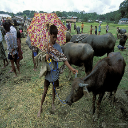

(1, 512)


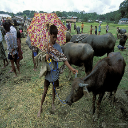

(1, 512)


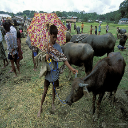

(1, 512)


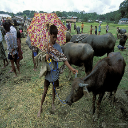

(1, 512)


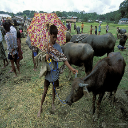

(1, 512)


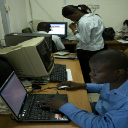

(1, 512)


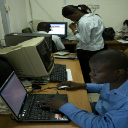

(1, 512)


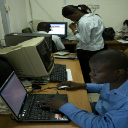

(1, 512)


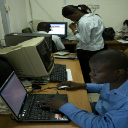

(1, 512)


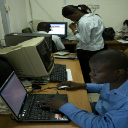

(1, 512)


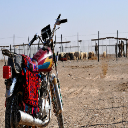

(1, 512)


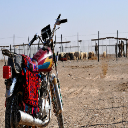

(1, 512)


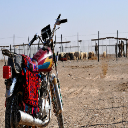

(1, 512)


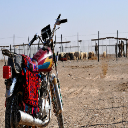

(1, 512)


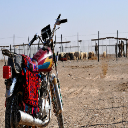

(1, 512)


In [9]:
for img, clip_embeddings in ds_train.take(15):
  image_to_show = tf.keras.preprocessing.image.array_to_img(img)
  display(image_to_show)
  print(clip_embeddings.shape)

In [14]:
import tensorflow as tf
import torch
import os
import matplotlib.pyplot as plt
os.chdir("/content/dl-fp/")
import clip_wrapper

class ClipCVAE(tf.keras.Model):
  def __init__(self, input_dim, latent_dim, dropout_rate):
    super(ClipCVAE, self).__init__()
    self.latent_dim = latent_dim
    self.input_dim = input_dim
    self.shape_input = (128, 128, 3)  # Adjust channel to include conditions if feasible
    self.dropout_prob = dropout_rate

    self.embedding_shrinker = tf.keras.layers.Dense(32)
    self.encoder_part1= tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=self.shape_input, name="encoder_part1_inputlayer"),
            tf.keras.layers.Conv2D(256, 3, strides=2, padding="same", kernel_initializer=tf.keras.initializers.HeNormal(), name="conv2d1"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(256,5, strides=2, padding="same", kernel_initializer=tf.keras.initializers.HeNormal(), name="conv2d2"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(128, 3, strides=2, padding="same", kernel_initializer=tf.keras.initializers.HeNormal(), name="conv2d3"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(128, 3, strides=2, padding="same", kernel_initializer=tf.keras.initializers.HeNormal(), name="conv2d4"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Flatten()])

  #n call, we will concatenate the output from the first part of the encoding with the CLIP embedding
    self.encoder_part2 = tf.keras.Sequential([
            tf.keras.layers.Dense(2048, kernel_initializer=tf.keras.initializers.HeNormal(), activation = "leaky_relu"),
            tf.keras.layers.Dense(2048, kernel_initializer=tf.keras.initializers.HeNormal(), activation="leaky_relu"),
            tf.keras.layers.Dense(1024, kernel_initializer=tf.keras.initializers.HeNormal()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU()

        ]
    )

    self.mu = tf.keras.layers.Dense(self.latent_dim, kernel_initializer=tf.keras.initializers.HeNormal())
    self.logv = tf.keras.layers.Dense(self.latent_dim, kernel_initializer=tf.keras.initializers.HeNormal())

#On peut toujours ajouter an input Layer for convention and covention precision
    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(8 * 8 * 256, kernel_initializer=tf.keras.initializers.HeNormal()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Reshape((8,8,256)),
            tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding="same", kernel_initializer=tf.keras.initializers.HeNormal()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(256, 5, strides=2, padding="same", kernel_initializer=tf.keras.initializers.HeNormal()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(128, 5, strides=2, padding="same", kernel_initializer=tf.keras.initializers.HeNormal()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(128, 3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.HeNormal()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(32, 5, strides=2, padding="same", kernel_initializer=tf.keras.initializers.HeNormal()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(3, 5, strides=1, padding="same", activation="sigmoid", kernel_initializer=tf.keras.initializers.HeNormal())
        ]
    )

  def compute_loss(self, inputs, reconstructed, logv, mu):
    inputs, _ = inputs
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(inputs, reconstructed)))
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(inputs, reconstructed, max_val=1.0))
    kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + logv - tf.square(mu) - tf.exp(logv)))
    total_loss = reconstruction_loss + 0.5 * kl_loss + 0.1 * ssim_loss
    return total_loss / BATCH_SIZE

  def call(self, args, training=False):
    x, embedding = args
    embedding = tf.squeeze(embedding, axis=1)

    # First part of the encoding
    e1 = self.encoder_part1(x)
    e1_w_embedding = tf.concat([e1, embedding], axis=-1)

    # Go through part 2 of encoder
    e2 = self.encoder_part2(e1_w_embedding)

    # Mu and Logv
    mu = self.mu(e2)
    logv = self.logv(e2)

    # Sample Z (reparameterization trick)
    sigma = tf.math.sqrt(tf.math.exp(logv))
    eps = tf.random.normal([BATCH_SIZE, self.latent_dim])
    z = mu + tf.multiply(sigma, eps)

    if training:
      dropout_rate = self.dropout_prob
      z = tf.nn.dropout(z, rate=dropout_rate)

    embedding = self.embedding_shrinker(embedding)
    # Concatenate z with embedding again
    z_w_embedding = tf.concat([z, embedding], axis=-1)

    # Decode!
    res = self.decoder(z_w_embedding)

    return res, mu, logv

  def train_step(self, data):
    # HOW CAN WE SAVE THE WEIGTHS AT THE END
      # clip_embeddings = clip_wrapper.batch_get_image_encodings(data)
      with tf.GradientTape() as tape:
          reconstruction, mu, logv = self(data, training=True)
          loss = self.compute_loss(data, reconstruction, logv, mu)
      grads = tape.gradient(loss, self.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
      return {'train loss': loss}

  def test_step(self, data):
    reconstruction, mu, logv = self(data, training=False)
    loss = self.compute_loss(data, reconstruction, logv, mu)
    return {'valid loss': loss}

  def show_image(self, capt):
    z = tf.random.normal(shape=[1, self.latent_dim])
    encoding = clip_wrapper.get_text_encoding(capt)
    encoding = self.embedding_shrinker(encoding)
    z = tf.concat([z, encoding], axis=-1)
    img = self.decoder(z).numpy()[0]
    plt.imshow(img)

In [15]:
# Make directory for checkpoints and weights. This will simply error out if it already exists
!mkdir /content/dl-fp/ckpts
!mkdir /content/dl-fp/weights

mkdir: cannot create directory ‘/content/dl-fp/ckpts’: File exists
mkdir: cannot create directory ‘/content/dl-fp/weights’: File exists


In [16]:
# Prepare for checkpoints
chk_pt = tf.keras.callbacks.ModelCheckpoint(
    "/content/dl-fp/ckpts/model_1_ckpt",
    monitor="val_valid",
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    initial_value_threshold=None,
)

In [18]:
cvae = ClipCVAE(input_dim=224*224, latent_dim=128, dropout_rate=0.3)
cvae.compile(optimizer=tf.keras.optimizers.Adam(0.0005))
cvae.fit(ds_train_batched, epochs=10, batch_size=BATCH_SIZE, validation_data=ds_valid_batched, callbacks=[chk_pt])
cvae.save_weights("/content/dl-fp/weights/cvae_weights.h5")

Epoch 1/10
797/797 [==============================] - 319s 382ms/step - train loss: 10238.7066 - val_valid loss: 10225.2666
Epoch 2/10
797/797 [==============================] - 313s 387ms/step - train loss: 9970.8412 - val_valid loss: 10007.7773
Epoch 3/10
797/797 [==============================] - 349s 433ms/step - train loss: 9930.7606 - val_valid loss: 9946.6270
Epoch 4/10
797/797 [==============================] - 343s 427ms/step - train loss: 9904.1168 - val_valid loss: 9880.0918
Epoch 5/10
797/797 [==============================] - 342s 426ms/step - train loss: 9884.0760 - val_valid loss: 9712.7354
Epoch 6/10
797/797 [==============================] - 311s 387ms/step - train loss: 9857.4920 - val_valid loss: 9627.3535
Epoch 7/10
797/797 [==============================] - 310s 385ms/step - train loss: 9847.5272 - val_valid loss: 9707.0361
Epoch 8/10
797/797 [==============================] - 311s 386ms/step - train loss: 9837.8372 - val_valid loss: 9735.7969
Epoch 9/10
797/797 [=

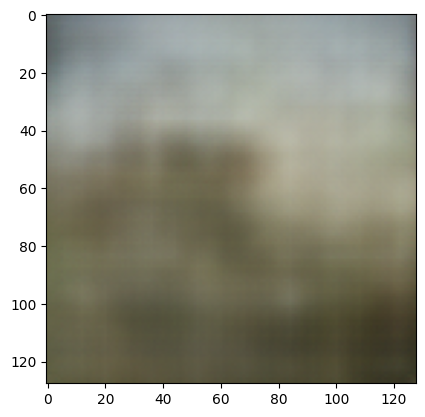

In [26]:
# Prediction
vae = ClipCVAE(input_dim=224*224, latent_dim=128, dropout_rate=0.3)
example_input = tf.random.normal((16, 128, 128, 3))
example_embedding = tf.random.normal((16, 1, 512))

# Dummy prediction to initialize model and be able to load weights
im = vae((example_input, example_embedding))[0]

vae.load_weights("/content/dl-fp/weights/cvae_weights.h5")
vae.show_image("blue sky")

In [19]:
# Save weights to Google Drive
!cp "/content/dl-fp/weights/cvae_weights.h5" "/content/drive/MyDrive/Deep Learning FP/Final Notebooks/Weights/cvae_weights_128x128_txtemb5_small_og_dropout.h5"